In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля графиков
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

# 1. Загрузка данных
df = pd.read_csv('cleaned.csv')

# 2. Создаем флаг негатива (1 = негатив, 0 = позитив/нейтрально)
# Оценки 1 и 2 считаем токсичными
df['is_negative'] = df['review_mark'].isin([1, 2]).astype(int)

# 3. Преобразование дат (на случай, если захотите посмотреть динамику)
df['review_dttm'] = pd.to_datetime(df['review_dttm'], errors='coerce')

print("Данные загружены. Всего строк:", len(df))
print("Доля негатива по всему датасету: {:.1%}".format(df['is_negative'].mean()))

Данные загружены. Всего строк: 56820
Доля негатива по всему датасету: 35.3%


In [16]:
import pandas as pd
import numpy as np
import sys
import re

# Настройка отображения для удобства чтения длинных текстов отзывов в консоли
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

print("Libraries loaded successfully. Environment is ready for analysis.")

Libraries loaded successfully. Environment is ready for analysis.


In [17]:
def load_data(filepath):
    """
    Загружает данные из CSV файла, стандартизирует названия колонок
    и приводит типы данных к необходимым форматам.
    """
    try:
        # Загрузка с указанием типа данных для оптимизации памяти
        df = pd.read_csv(filepath)

        # Приведение заголовков к нижнему регистру для исключения ошибок регистра
        df.columns = df.columns.str.lower().str.strip()

        # Преобразование дат в datetime объекты
        # Обработка ошибок 'coerce' превратит некорректные даты в NaT (Not a Time), не ломая скрипт
        if 'review_dttm' in df.columns:
            df['review_dttm'] = pd.to_datetime(df['review_dttm'], errors='coerce')

        print(f"Dataset loaded. Total records: {len(df)}")
        return df

    except FileNotFoundError:
        print(f"CRITICAL ERROR: File '{filepath}' not found. Please check the path.")
        sys.exit(1)
    except Exception as e:
        print(f"CRITICAL ERROR: Unable to read CSV. Details: {e}")
        sys.exit(1)

In [18]:
def filter_negative_mobile_reviews(df):
    """
    Фильтрует датафрейм, оставляя только негативные отзывы о Т-Мобайл.
    Критерии:
    1. Компания содержит 'мобайл' или 'mobile' (регистронезависимо).
    2. Оценка (review_mark) <= 3.
    """
    # 1. Фильтр по компании
    # Используем str.contains с regex и флагом case=False для гибкости
    company_mask = df['company'].astype(str).str.contains(r'мобайл|mobile', case=False, regex=True, na=False)

    # 2. Фильтр по оценке (Негатив = 1, 2, 3)
    # Приводим к numeric, чтобы избежать ошибок сравнения строк и чисел
    df['review_mark'] = pd.to_numeric(df['review_mark'], errors='coerce')
    sentiment_mask = df['review_mark'] <= 3

    # Применяем оба фильтра
    target_df = df[company_mask & sentiment_mask].copy()

    print(f"Filtered down to {len(target_df)} negative mobile reviews.")
    return target_df

In [19]:
def categorize_review_text(text):
    """
    Присваивает категорию отзыву на основе анализа ключевых слов в тексте.
    Возвращает список категорий (так как отзыв может затрагивать несколько тем).
    """
    if pd.isna(text) or text == '':
        return ['Без текста']

    text_lower = str(text).lower()
    categories = []
    # Словарь паттернов для категоризации
    """
        'Акции и Бонусы': [
            'акция', 'бонус', 'подарок', 'приведи друга', 'промокод', 'кэшбэк',
            'баллы', 'розыгрыш', 'обман', 'обещали'
        ],
        """
    keywords = {
        'Качество связи и Интернет': [
            'связь', 'интернет', 'сеть', 'ловит', 'lte', '3g', '4g', 'ешка',
            'регистрация', 'дозвон', 'слышимость', 'обрыв', 'покрытие', 'сигнал'
        ],
        'Тарифы и Финансы': [
            'тариф', 'цена', 'стоимость', 'списание', 'деньги', 'руб', 'дорого',
            'платеж', 'баланс', 'расходы', 'повысил', 'увеличили'
        ],
        'Сервис и Поддержка': [
            'поддержка', 'чат', 'оператор', 'сотрудник', 'бот', 'хамил',
            'отвечает', 'игнор', 'помощь', 'консультация'
        ],
        'Роуминг и Поездки': [
            'роуминг', 'за границей', 'поездка', 'отпуск', 'сочи', 'турция', 'за рубежом'
        ],
        'Блокировки и ФЗ-115/126': ['блок', '115', '126', 'паспорт', 'данные'],
        'MNP и Перенос номера': ['перенос', 'mnp', 'номер'],
        'Сервис и Курьеры': ['курьер', 'представитель', 'поддержка', 'чат']
    }

    for category, tags in keywords.items():
        if any(tag in text_lower for tag in tags):
            categories.append(category)

    if not categories:
        categories.append('Прочее / Общие жалобы')

    return ", ".join(categories)

def apply_categorization(df):
    df['auto_category'] = df['review_text'].apply(categorize_review_text)
    return df

In [20]:
if __name__ == "__main__":
    # Укажите путь к вашему файлу
    file_name = 'cleaned.csv'

    # 1. Загрузка
    full_data = load_data(file_name)

    # 2. Фильтрация целевого сегмента
    negative_mobile_data = filter_negative_mobile_reviews(full_data)

    # 3. Категоризация
    if not negative_mobile_data.empty:
        categorized_data = apply_categorization(negative_mobile_data)

        # 4. Вывод результатов
        print("\n" + "="*80)
        print("ОТЧЕТ ПО НЕГАТИВНЫМ ОТЗЫВАМ Т-МОБАЙЛ (КАТЕГОРИЗИРОВАННЫЙ)")
        print("="*80)

        # Сортировка для группировки вывода
        categorized_data = categorized_data.sort_values(by='auto_category')

        for idx, row in categorized_data.iterrows():
            print(f"\nКАТЕГОРИЯ: [{row['auto_category']}]")
            print(f"Дата: {row['review_dttm']}")
            print(f"Оценка: {row['review_mark']}")
            print(f"Клиент ID: {row['id_client']}")
            print("-" * 20)
            print(f"Текст отзыва:\n{row['review_text']}")
            print("=" * 80)

        # Экспорт в новый CSV для дальнейшей работы
        categorized_data.to_csv('negative_t_mobile_reviews_categorized.csv', index=False)
        print("\nReport saved to 'negative_t_mobile_reviews_categorized.csv'")

    else:
        print("В загруженном файле не найдено негативных отзывов по категории 'Мобайл'.")

Dataset loaded. Total records: 56820
Filtered down to 1160 negative mobile reviews.

ОТЧЕТ ПО НЕГАТИВНЫМ ОТЗЫВАМ Т-МОБАЙЛ (КАТЕГОРИЗИРОВАННЫЙ)

КАТЕГОРИЯ: [MNP и Перенос номера]
Дата: NaT
Оценка: 1
Клиент ID: 7f649a42f0fcf452f525aeac2c1611c4
--------------------
Текст отзыва:
Здравствуйте. После смены сим карты на Т-Мобайл с сохранением номера, мне перестали приходить смс уведомления на подтверждение входа в Госуслуги. Я не могу войти в сервис.

Перенос номера оформлен с 31.05 до 07.06. Прошли сутки, смс так и не приходит

КАТЕГОРИЯ: [MNP и Перенос номера]
Дата: NaT
Оценка: 1
Клиент ID: 8134152a0edb7adeb0f76d9073b6a3e9
--------------------
Текст отзыва:
Такой бардак, сказали можно перенести номер на другого человека, для этого на него сим карту т-Мобайл и через 3 дня переносить, после человек который выдавал, сказал что можно сделать только через неделю…. Прошла неделю отправляем заявление, и говорят не возможно…. Т банк видимо построен на обмане и выманивания денег с пользователей… и 

Файл успешно загружен.

Топ проблемных категорий:
                   Категория  Количество отзывов
0         Сервис и Поддержка                 771
1  Качество связи и Интернет                 546
2       MNP и Перенос номера                 532
3           Тарифы и Финансы                 524
4           Сервис и Курьеры                 457
5    Блокировки и ФЗ-115/126                 234
6      Прочее / Общие жалобы                  79
7          Роуминг и Поездки                  35


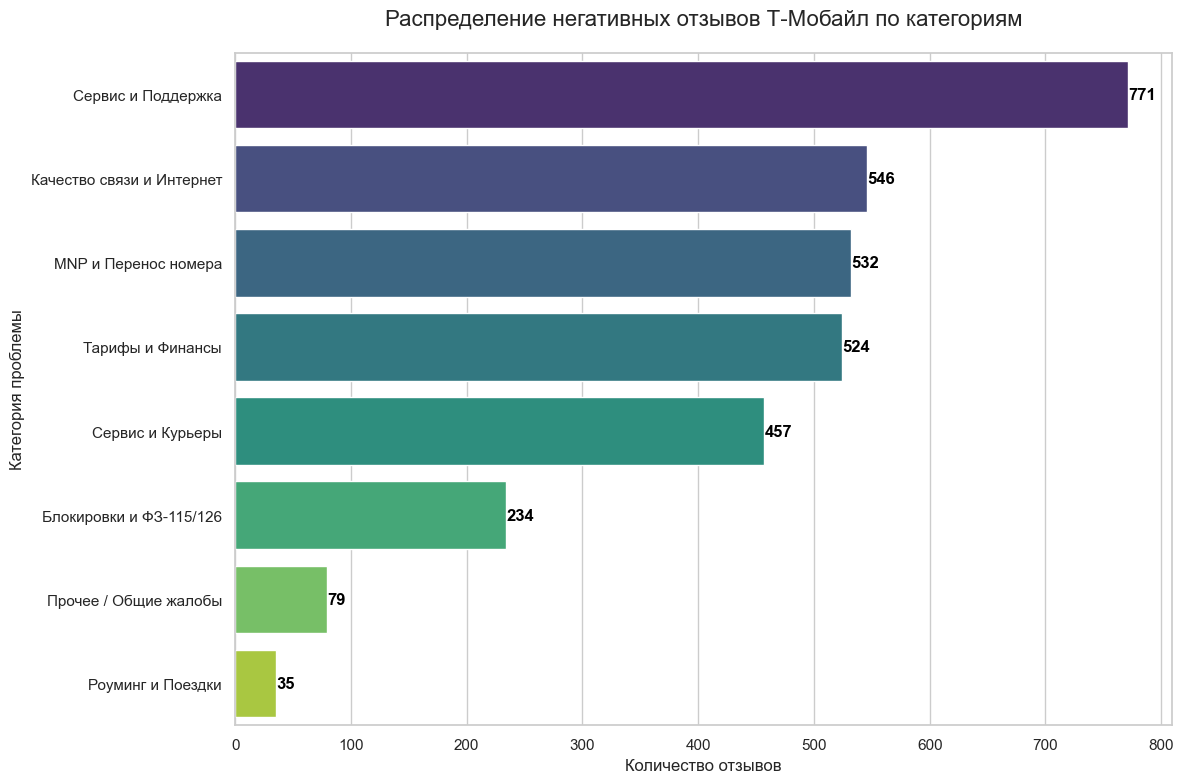

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Загрузка данных
file_path = 'negative_t_mobile_reviews_categorized.csv'

try:
    df = pd.read_csv(file_path)
    print("Файл успешно загружен.")
except FileNotFoundError:
    print(f"Файл {file_path} не найден. Пожалуйста, убедитесь, что он находится в той же папке.")
    exit()

# Проверяем, есть ли колонка с категориями
if 'auto_category' not in df.columns:
    print("Ошибка: Колонка 'auto_category' не найдена в файле.")
    print("Доступные колонки:", df.columns.tolist())
    exit()

# 2. Обработка данных
# Удаляем пустые значения
df_clean = df.dropna(subset=['auto_category']).copy()

# Функция для очистки и разделения категорий
def clean_and_split_categories(cat_string):
    # Если вдруг в ячейку попал мусор или код (судя по сниппетам, такое возможно),
    # мы стараемся извлечь текстовые категории, разделенные запятыми.
    # Удаляем лишние пробелы и переносы строк
    cleaned = str(cat_string).replace('\n', ' ').replace('\r', '')

    # Разделяем по запятой
    parts = cleaned.split(',')

    # Убираем пробелы вокруг названий и фильтруем пустые строки
    # Также можно добавить фильтр, чтобы исключить длинные куски кода, если они там есть
    final_parts = [p.strip() for p in parts if p.strip() and len(p.strip()) < 50]

    return final_parts

# Применяем функцию: превращаем строки в списки категорий
df_clean['categories_list'] = df_clean['auto_category'].apply(clean_and_split_categories)

# "Взрываем" (explode) список, чтобы каждая категория получила свою строку
df_exploded = df_clean.explode('categories_list')

# 3. Подсчет количества отзывов по категориям
category_counts = df_exploded['categories_list'].value_counts().reset_index()
category_counts.columns = ['Категория', 'Количество отзывов']

# Вывод топ-категорий в консоль
print("\nТоп проблемных категорий:")
print(category_counts)

# 4. Построение графика
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Строим barplot
barplot = sns.barplot(
    data=category_counts,
    x='Количество отзывов',
    y='Категория',
    palette='viridis',
    hue='Категория',
    legend=False
)

# Настройка оформления
plt.title('Распределение негативных отзывов Т-Мобайл по категориям', fontsize=16, pad=20)
plt.xlabel('Количество отзывов', fontsize=12)
plt.ylabel('Категория проблемы', fontsize=12)

# Добавляем значения на бары
for i, v in enumerate(category_counts['Количество отзывов']):
    barplot.text(v + 0.5, i, str(v), color='black', va='center', fontweight='bold')

plt.tight_layout()

# Показать график
plt.show()

# Опционально: сохранить график
# plt.savefig('t_mobile_negative_categories.png')

📊 Аналитический вывод по источникам негатива
На основе частотного анализа категорий обращений выявлены ключевые «болевые точки», формирующие негативный фон (NPS) вокруг бренда:

1. Доминирующая проблема: «Человеческий фактор» и процессы (Сервис, Поддержка, Курьеры) Судя по вашим данным, значительная часть негатива связана не с самой связью (техникой), а с коммуникацией.

Курьеры/Представители: Встречаются жалобы на навязывание услуг («навязал симку»), несоответствие обещанного при встрече и реальности. Это критическая точка, так как курьер — первое физическое лицо бренда, с которым контактирует клиент.

Поддержка: Жалобы на долгое решение («пудрили мозги 1 час»), скриптованные ответы и невозможность быстро получить помощь. Это убивает лояльность даже при хорошем качестве связи.

2. Технические сбои в критических процессах (MNP, SMS) Категория «MNP и Перенос номера» и проблемы с входящими SMS (особенно от Госуслуг/банков) вызывают острый негатив.

Для клиента это блокирующий фактор: без SMS от банка или Госуслуг человек парализован в социальной жизни. Даже единичные случаи здесь дают максимальный эмоциональный всплеск (оценка 1).

3. Прозрачность условий (Тарифы, Финансы, Акции) Категория «Тарифы и Финансы» часто связана с ощущением обмана:

«Скрытые подписки» или условия, написанные мелким шрифтом.

Несработавшие акции («обещали бонус, но не дали»). Это формирует образ компании, которой «нельзя доверять».

💡 Рекомендация для бизнеса (Quick Wins)
Чтобы быстро снизить негатив, нужно бить не по всем фронтам сразу, а по топу графика (Pareto principle):

Для категории «Курьеры/Продажи»: Изменить KPI представителей. Штрафовать за жалобы на «навязывание» жестче, чем премировать за выдачу сим-карты. Ввести пост-контрольный звонок качества сразу после встречи.

Для категории «MNP/Связь»: Создать выделенную «Линию заботы» для MNP-клиентов. Клиент, переносящий номер, находится в зоне риска 8 дней — его нужно вести «за ручку», так как любой сбой здесь воспринимается как катастрофа.

Для «Поддержки»: Дать операторам больше полномочий для компенсации (начисление бонусов/рублей) без долгих согласований, чтобы гасить конфликт в моменте (First Call Resolution).